# Solve NFW equations with lenstronomy

In [301]:
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [320]:
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)  # Example values
# Lens and source redshift
z_l = 1
z_s = 1.5
lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)

# NFW profile parameters
M200 = 1e15  # Solar masses

# Empirical mass-concentration relation (Dutton & Macciò 2014)
def concentration(M200, z):
    A = 5.71
    B = -0.084
    C = -0.47
    c200 = A * (M200 / 1e12)**B * (1 + z)**C
    return c200

# Calculate concentration parameter
c200 = concentration(M200, z_l)

# Convert M200 to lensing parameters
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=M200, c=c200)

rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(Rs_angle=Rs_angle, alpha_Rs=alpha_Rs)

In [321]:
lens_model_list = ['NFW']
lens_model = LensModel(lens_model_list)
kwargs_nfw = [{'Rs': Rs, 'alpha_Rs': alpha_Rs, 'center_x': 0, 'center_y': 0}]

In [322]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model)
x_source, y_source = 4.774774774774775, 4.774774774774775
x_image, y_image = solver.image_position_from_source(
                sourcePos_x=x_source,
                sourcePos_y=y_source,
                kwargs_lens=kwargs_nfw)
mag = lens_model.magnification(x_image, y_image, kwargs_nfw)

print(f"Source position: ({x_source}, {y_source})")
print(f"Image position: ({x_image}, {y_image})")
print(f"Magnification: {mag}")

## uncomment to test for multiple source positions
# x_source_arr, y_source_arr = np.linspace(0, 10, 100), np.linspace(0, 10, 100)
# x_image_arr, y_image_arr = [], []
# mag_arr = []
# for x_source, y_source in zip(x_source_arr, y_source_arr):
#     x_image, y_image = solver.image_position_from_source(
#                     sourcePos_x=x_source,
#                     sourcePos_y=y_source,
#                     kwargs_lens=kwargs_nfw)
#     x_image_arr.append(x_image)
#     y_image_arr.append(y_image)
#     mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
#     mag_arr.append(mag)


Source position: (4.774774774774775, 4.774774774774775)
Image position: ([-1.36710396 -0.12581829], [-1.36710396 -0.12581829])
Magnification: [-0.13269688  0.00168513]


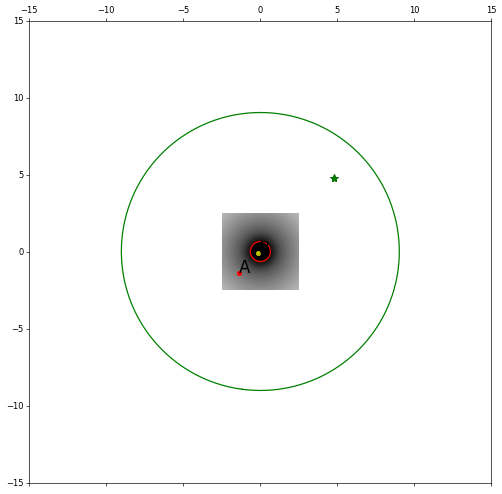

In [323]:
from lenstronomy.Plots import lens_plot

fig, ax = plt.subplots(figsize=(10,10),dpi=60)
beta_ra, beta_dec = 4.774774774774775, 4.774774774774775
lens_plot.lens_model_plot(ax, 
    lensModel=lensModel, 
    kwargs_lens=kwargs_nfw, 
    sourcePos_x=beta_ra, 
    sourcePos_y=beta_dec, 
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=True,
)
                      
# image
# add point size to make it visible
plt.plot(x_image[0], y_image[0],marker='.',ls='None', color='r', markersize=10, label='Image 1')
plt.plot(x_image[1], y_image[1],marker='.',ls='None', color='y', markersize=10, label='Image 2')

# # source
plt.plot(beta_ra, beta_dec,marker='*',ls='None', color='g', markersize=10, label='Source')

ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
plt.show()

## To show the size of the custic is related to the einstein radius

* We will sample source position within boundary define by the einstein radius.

In [318]:
# function to get the Einstein radius
def einstein_radius_nfw(M200, zl, zs, cosmo):

    M200 = M200 * u.M_sun.to(u.kg)  # Convert solar mass to kg
    # Constants in SI units
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    c = 299792458  # speed of light in m/s

    # Calculate critical density
    rho_crit = cosmo.critical_density(zl).to(u.kg / u.m**3).value

    # Calculate r200
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)

    # angular diameter distance
    d_A_L = cosmo.angular_diameter_distance(zl).to(u.m).value
    d_A_S = cosmo.angular_diameter_distance(zs).to(u.m).value
    d_A_LS = cosmo.angular_diameter_distance_z1z2(zl, zs).to(u.m).value

    # sigma_crit
    sigma_crit = c**2 / (4 * np.pi * G) * d_A_S / (d_A_L * d_A_LS)

    # Einstein radius
    # Einstein radius calculation
    theta_E = (M200 / (2 * r200 * sigma_crit * d_A_L))  # radians

    # Convert to arcseconds
    theta_E_arcsec = theta_E * 206265

    return theta_E_arcsec

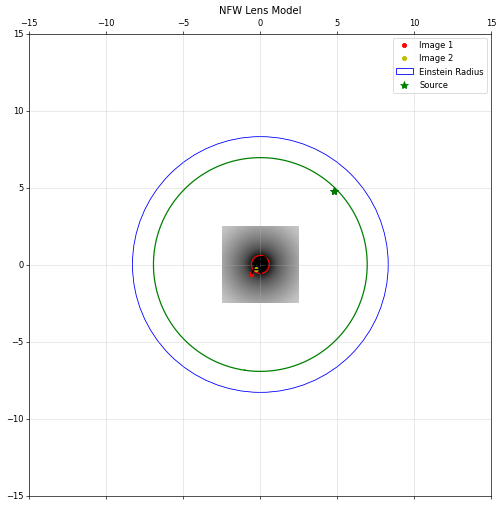

In [319]:
# plot lens_plot with Einstein radius
fig, ax = plt.subplots(figsize=(10,10),dpi=60)
beta_ra, beta_dec = 4.774774774774775, 4.774774774774775
lens_plot.lens_model_plot(ax, 
    lensModel=lensModel, 
    kwargs_lens=kwargs_nfw, 
    sourcePos_x=beta_ra, 
    sourcePos_y=beta_dec, 
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=True,
)

# image
# add point size to make it visible
plt.plot(x_image[0], y_image[0],marker='.',ls='None', color='r', markersize=10, label='Image 1')
plt.plot(x_image[1], y_image[1],marker='.',ls='None', color='y', markersize=10, label='Image 2')

# circle wrt einsrein radius
theta_E = einstein_radius_nfw(M200, z_l, z_s, cosmology)
circle = plt.Circle((0, 0), theta_E, color='b', fill=False, label='Einstein Radius')
ax.add_artist(circle)

# source
plt.plot(beta_ra, beta_dec,marker='*',ls='None', color='g', markersize=10, label='Source')
# legend
plt.legend()
plt.title('NFW Lens Model')

ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
# show grid
plt.grid(alpha=0.4)
# save figure
plt.savefig('nfw_lens_model2.png')
plt.show()


In [324]:
# to test for multiple source positions
x_source_arr, y_source_arr = np.linspace(0, 15, 1000), np.linspace(0, 15, 1000)
x_image_arr, y_image_arr = [], []
mag_arr = []
for x_source, y_source in zip(x_source_arr, y_source_arr):
    x_image, y_image = solver.image_position_from_source(
                    sourcePos_x=x_source,
                    sourcePos_y=y_source,
                    kwargs_lens=kwargs_nfw)
    x_image_arr.append(list(x_image))
    y_image_arr.append(list(y_image))
    mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
    mag_arr.append(list(mag))

In [325]:
# print magnification and source position
for i in range(len(x_source_arr)):
    print(f"Source position: ({x_source_arr[i]}, {y_source_arr[i]})")
    print(f"Image position: ({x_image_arr[i]}, {y_image_arr[i]})")
    print(f"Magnification: {mag_arr[i]}")
    print("\n")

Source position: (0.0, 0.0)
Image position: ([3.4526567390103997, -3.4526567390103997, 3.4526567390103997, -4.553503814796998, 4.553503814796998, -3.4526567390103997, 4.553503814796998, -4.553503814796998, -4.040744705422042, 4.040744705422042, 4.040744705422042, -4.040744705422042, -3.042102775747364, 4.837442118576165, -4.837442118576165, -3.042102775747364, -4.837442118576165, 3.042102775747364, 4.837442118576165, 3.042102775747364], [4.553503814796998, -4.553503814796998, -4.553503814796998, -3.4526567390103993, -3.4526567390103993, 4.553503814796998, 3.4526567390103993, 3.4526567390103993, -4.040744705422042, -4.040744705422042, 4.040744705422042, 4.040744705422042, -4.837442118576165, -3.0421027757473644, 3.0421027757473644, 4.837442118576165, -3.0421027757473644, -4.837442118576165, 3.0421027757473644, 4.837442118576165])
Magnification: [-191642537334914.72, -191642537334914.72, -191642537334914.72, -200159983438688.72, -200159983438688.72, -191642537334914.72, -200159983438688.

'ler' is a statistics based Python package specifically designed for computing detectable rates of both lensed and unlensed GW events, catering to the requirements of the LIGO Virgo KAGRA Scientific Collaboration and astrophysics research scholars. The core functionality of 'ler' intricately hinges upon the interplay of various components which include sampling the properties of compact binary sources, lens galaxies characteristics, solving lens equations to derive properties of resultant images, and computing detectable GW rates. This comprehensive functionality builds on the leveraging of array operations and linear algebra from the numpy library, enhanced by interpolation methods from scipy and Python’s multiprocessing capabilities. Efficiency is further boosted by the numba library's Just In Time (njit) compilation, optimizing extensive numerical computations and employing the inverse transform sampling method to replace more cumbersome rejection sampling. The modular design of 'ler' not only optimizes speed and functionality but also ensures adaptability and upgradability, supporting the integration of additional statistics as research evolves. Currently, 'ler' is an important tool in generating simulated GW events, both lensed and unlensed, and provides astrophysically accurate distributions of event related parameters for both detectable and non detectable events. This functionality aids in event validation and enhances the forecasting of detection capabilities across various GW detectors to study such events. The architecture of the 'ler' API facilitates seamless compatibility with other software packages, allowing researchers to integrate and utilize its functionalities based on specific scientific requirements.

ler is a statistics-based Python package specifically designed for computing detectable rates of both lensed and unlensed GW events, catering to the requirements of the LIGO-Virgo-KAGRA Scientific Collaboration and astrophysics research scholars. The core functionality of ler intricately hinges upon the interplay of various components which include sampling the properties of compact-binary sources, lens galaxies characteristics, solving lens equations to derive properties of resultant images, and computing detectable GW rates. This comprehensive functionality builds on the leveraging of array operations and linear algebra from the numpy library, enhanced by interpolation methods from scipy and Python’s multiprocessing capabilities. Efficiency is further boosted by the numba library's Just-In-Time (njit) compilation, optimizing extensive numerical computations and employing the inverse transform sampling method to replace more cumbersome rejection sampling. The modular design of ler not only optimizes speed and functionality but also ensures adaptability and upgradability, supporting the integration of additional statistics as research evolves. Currently, ler is an important tool in generating simulated GW events—both lensed and unlensed—and provides astrophysically accurate distributions of event-related parameters for both detectable and non-detectable events. This functionality aids in event validation and enhances the forecasting of detection capabilities across various GW detectors to study such events. The architecture of the ler API facilitates seamless compatibility with other software packages, allowing researchers to integrate and utilize its functionalities based on specific scientific requirements.

\(ler\) is a statistics-based Python package specifically designed for computing detectable rates of both lensed and unlensed GW events, catering to the requirements of the LIGO-Virgo-KAGRA Scientific Collaboration and astrophysics research scholars. The core functionality of \(ler\) intricately hinges upon the interplay of various components which include sampling the properties of compact-binary sources, lens galaxies characteristics, solving lens equations to derive properties of resultant images, and computing detectable GW rates. This comprehensive functionality builds on the leveraging of array operations and linear algebra from the \emph{numpy} library, enhanced by interpolation methods from \emph{scipy} and Python's \emph{multiprocessing} capabilities. Efficiency is further boosted by the \emph{numba} library's Just-In-Time (\emph{njit}) compilation, optimizing extensive numerical computations and employing the inverse transform sampling method to replace more cumbersome rejection sampling. The modular design of \(ler\) not only optimizes speed and functionality but also ensures adaptability and upgradability, supporting the integration of additional statistics as research evolves. Currently, \(ler\) is an important tool in generating simulated GW events---both lensed and unlensed---and provides astrophysically accurate distributions of event-related parameters for both detectable and non-detectable events. This functionality aids in event validation and enhances the forecasting of detection capabilities across various GW detectors to study such events. The architecture of the \(ler\) API facilitates seamless compatibility with other software packages, allowing researchers to integrate and utilize its functionalities based on specific scientific requirements.